In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.utils.validation import check_is_fitted

In [2]:
# my data
data = pd.read_csv('/home/giwrikas/Downloads/Morphemic_datasets/all-4 (1).csv')
cols = ["memory_alloc","cpu_alloc","cpu_usage","memory","number_instances"]
data[cols] = data[cols].replace({ 0:np.nan})
data = data.dropna(subset=['number_instances', 'memory_alloc','cpu_alloc'])
data = data.drop(columns=['Unnamed: 0'])

#### Here we are doing a minor modification at the data in order not to have values like 1000000000.0 (and not to observe very big deviation)

In [3]:
data['cpu_alloc'] = data['cpu_alloc'].replace(100000000.0, 1)
data['cpu_alloc'] = data['cpu_alloc'].replace(200000000.0, 2)
data['cpu_alloc'] = data['cpu_alloc'].replace(300000000.0, 3)
data['cpu_alloc'] = data['cpu_alloc'].replace(400000000.0, 4)

In [4]:
data['memory_alloc'] = data['memory_alloc'].replace(248000000.0, 248)

In [5]:
data.head()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
13,0.000000,0.000000,1.0,6960.363826,0.000000,39.366667,2.0,9.718443e+06,32.0
14,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
15,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
16,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
17,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0


In [6]:
data = data.round(decimals=2)

In [7]:
data.head()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
13,0.00,0.00,1.0,6960.36,0.00,39.37,2.0,9718442.67,32.0
14,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
15,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
16,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
17,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0


In [8]:
data.shape

(30507, 9)

In [9]:
# Data Description
data.describe()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
count,30507.000000,30507.000000,30507.000000,30507.000000,30507.000000,29608.000000,30507.000000,2.960900e+04,30507.000000
mean,22.391686,12.816734,1.366047,507.126632,61.012693,38.267292,2.518865,3.148796e+07,98.991051
std,63.763678,37.790858,0.790343,2753.333043,41.012961,9.283692,1.483380,6.424793e+06,84.894916
min,0.000000,0.000000,1.000000,0.000000,0.000000,14.870000,1.000000,2.083499e+06,32.000000
25%,0.000000,0.000000,1.000000,0.000000,7.970000,30.700000,2.000000,2.705818e+07,56.000000
50%,1.000000,0.330000,1.000000,1.520000,66.740000,39.235000,2.000000,3.301786e+07,56.000000
75%,22.110000,10.140000,1.000000,7.310000,100.000000,45.430000,2.000000,3.570483e+07,56.000000
max,636.000000,322.000000,5.000000,55029.400000,218.220000,73.400000,7.000000,5.108668e+07,248.000000


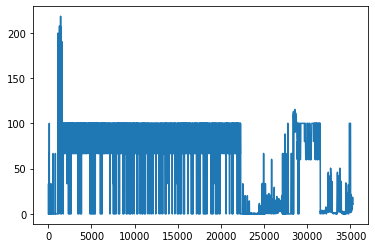

In [10]:
data['performance'].plot()

In [11]:
data[['performance', 'served_request','request_rate', 'response_time','cpu_alloc', 'memory_alloc', 'number_instances']][2000:20000]

,performance,served_request,request_rate,response_time,cpu_alloc,memory_alloc,number_instances
2300,100.00,0.0,0.33,0.00,2.0,56.0,1.0
2301,100.00,0.0,0.33,1.35,2.0,56.0,1.0
2302,100.00,0.0,0.33,1.35,2.0,56.0,1.0
2303,100.00,0.0,0.33,1.35,2.0,56.0,1.0
2304,100.00,0.0,0.33,1.35,2.0,56.0,1.0
...,...,...,...,...,...,...,...
23040,0.29,25.2,12.40,459.33,1.0,248.0,2.0
23041,20.11,25.2,12.40,459.33,1.0,248.0,2.0
23042,20.11,28.0,12.40,459.33,1.0,248.0,2.0
23043,20.11,28.0,12.40,459.33,1.0,248.0,2.0


#### To response time δεν πρεπει να ειναι 0 οπότε θα διαγραψουμε τις γραμμες που συμβαινει αυτο. (Διαφορετικά θα προσπαθήσουμε να κάνουμε missing value imputation στο response time - αν βελτιωνει τα αποτελεσματα)

In [12]:
data[data['response_time']==0]

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
215,0.0,0.0,1.0,0.0,0.0,NaN,2.0,NaN,32.0
216,0.0,0.0,1.0,0.0,0.0,NaN,2.0,NaN,32.0
217,0.0,0.0,1.0,0.0,0.0,NaN,2.0,NaN,32.0
218,0.0,0.0,1.0,0.0,0.0,NaN,2.0,NaN,32.0
219,0.0,0.0,1.0,0.0,0.0,NaN,2.0,NaN,32.0
...,...,...,...,...,...,...,...,...,...
34996,0.0,0.0,2.0,0.0,100.0,19.28,3.0,29794304.0,248.0
34997,0.0,0.0,2.0,0.0,100.0,19.28,3.0,29794304.0,248.0
34998,0.0,0.0,2.0,0.0,100.0,19.28,3.0,29794304.0,248.0
34999,0.0,0.0,2.0,0.0,100.0,19.28,3.0,29794304.0,248.0


In [13]:
data.shape

(30507, 9)

In [14]:
data.isna().sum()

served_request        0
request_rate          0
number_instances      0
response_time         0
performance           0
cpu_usage           899
cpu_alloc             0
memory              898
memory_alloc          0
dtype: int64

In [15]:
1600/30500   ### 5% ειναι περιπου το ποσοστο των nan στο σετ δεδομενων 

0.05245901639344262

In [16]:
data_2 = data.drop(data[data['response_time'] == 0.000000 ].index) 

In [17]:
data_2.isna().sum()

served_request       0
request_rate         0
number_instances     0
response_time        0
performance          0
cpu_usage           59
cpu_alloc            0
memory              63
memory_alloc         0
dtype: int64

In [18]:
data_2.shape

(19925, 9)

In [19]:
data_2 = data_2.round(decimals=2)

#### Insert a new variable according to the formula below (θα δουμε αν θα τη χρησιμοποιησουμε)

In [20]:
data_2['new_performance'] = (data_2['served_request']*data_2['request_rate'])/(data_2['response_time']*data_2['number_instances'])

In [21]:
data_2[['performance', 'new_performance', 'request_rate', 'response_time', 'served_request']]

,performance,new_performance,request_rate,response_time,served_request
13,0.00,0.000000,0.00,6960.36,0.00
14,33.33,0.000000,8.33,6960.36,0.00
15,33.33,0.000000,8.33,6960.36,0.00
16,33.33,0.024330,8.33,6960.36,20.33
17,33.33,0.024330,8.33,6960.36,20.33
...,...,...,...,...,...
35263,10.67,33.975824,16.57,6.41,39.43
35264,10.67,33.975824,16.57,6.41,39.43
35265,10.67,16.025389,16.57,13.59,39.43
35266,10.67,16.025389,16.57,13.59,39.43


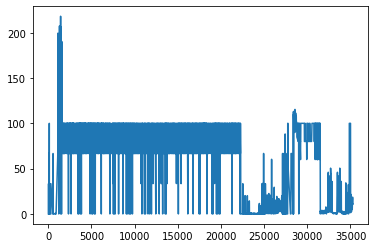

In [22]:
data_2['performance'].plot()

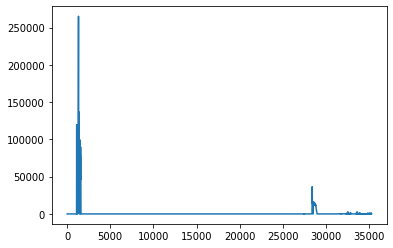

In [23]:
data_2['new_performance'].plot()

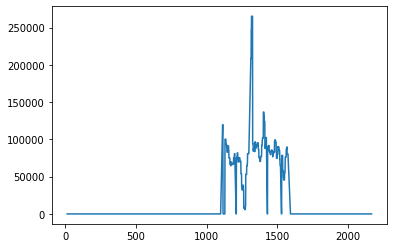

In [24]:
data_2['new_performance'][0:1000].plot()

In [25]:
data_3 = data_2.reset_index()
data_3 = data_3.drop(columns=['index'])
data_3.head()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc,new_performance
0,0.00,0.00,1.0,6960.36,0.00,39.37,2.0,9718442.67,32.0,0.00000
1,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0,0.00000
2,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0,0.00000
3,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0,0.02433
4,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0,0.02433


In [26]:
data_2['performance']

13        0.00
14       33.33
15       33.33
16       33.33
17       33.33
         ...  
35263    10.67
35264    10.67
35265    10.67
35266    10.67
35267    10.67
Name: performance, Length: 19925, dtype: float64

In [27]:
data_2['performance'].equals(data_2['new_performance'])

False

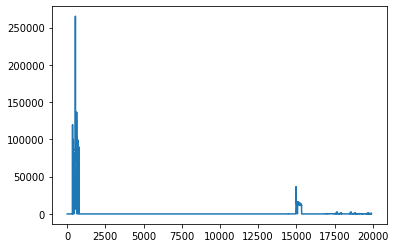

In [28]:
data_3['new_performance'].plot()

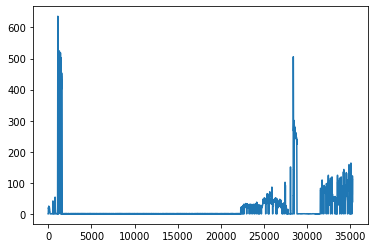

In [29]:
data['served_request'].plot()

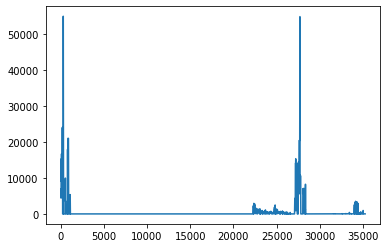

In [30]:
data['response_time'].plot()

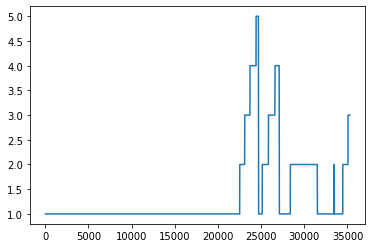

In [31]:
data['number_instances'].plot()

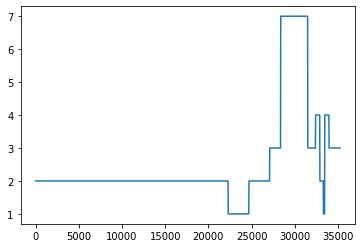

In [32]:
data['cpu_alloc'].plot()

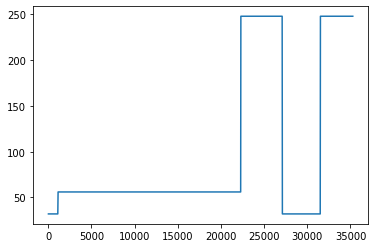

In [33]:
data['memory_alloc'].plot()

# Data Imputation technique 1

# Missing Values Imputation 
#### We are using an inheritance from the sklearn.base classes (BaseEstimator, TransformerMixin). 

# Group Data according to configuration and then for each configuration take the mean or the meadian

In [34]:
#Missing Values Imputation 

class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.

    Parameters
    ----------
    group_cols : list
        List of columns used for calculating the aggregated value
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''

    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        #assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'

        self.group_cols = group_cols
        self.target = target
        self.metric = metric

    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'

        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)#
        
        print(impute_map)
        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')

        X = X.copy()

        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])

        return X.values


conf_columns = ['number_instances', 'cpu_alloc', 'memory_alloc' ]

for col_name in data.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        imp = GroupImputer(group_cols=conf_columns,
                           target=col_name,
                           metric='median')

        df_imp = pd.DataFrame(imp.fit_transform(data),
                              columns=data.columns)



for col_name in data.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        print(f'data contains {sum(pd.isnull(data[col_name]))} missing values.')
        print(f'df_imp contains {sum(pd.isnull(df_imp[col_name]))} missing values.')



    number_instances  cpu_alloc  memory_alloc  served_request
0                1.0        1.0         248.0           22.33
1                1.0        2.0          32.0            0.00
2                1.0        2.0          48.0          636.00
3                1.0        2.0          56.0            0.00
4                1.0        2.0         248.0           44.67
5                1.0        3.0          32.0            5.00
6                1.0        3.0         248.0           72.33
7                1.0        4.0         248.0           90.67
8                1.0        6.0          32.0           58.33
9                2.0        1.0         248.0           25.20
10               2.0        2.0         248.0           46.80
11               2.0        3.0         248.0           72.40
12               2.0        6.0          32.0          141.00
13               2.0        7.0          32.0            0.60
14               3.0        1.0         248.0           24.29
15      

In [35]:
df_imp.isna().sum()

served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64

# Data imputation technique 2

In [38]:
data_cols = data_3.columns

def split(df, group_cols):
     gb = df.groupby(group_cols)
     return [gb.get_group(x) for x in gb.groups]

group_cols  = ['number_instances', 'cpu_alloc', 'memory_alloc' ]
data = split(data_3,group_cols )


# Check in which dataset appears nan values, and how many they are

In [39]:
print(data[0].isna().sum(),
data[1].isna().sum(),
data[2].isna().sum(),
data[3].isna().sum(),
data[4].isna().sum(),
data[5].isna().sum(),
data[6].isna().sum(),
data[7].isna().sum(),
data[8].isna().sum(),
data[9].isna().sum(),
data[10].isna().sum(),
data[11].isna().sum(),
data[12].isna().sum(),
data[13].isna().sum(),
data[14].isna().sum(),
data[15].isna().sum(),
data[16].isna().sum(),
data[17].isna().sum(),
data[18].isna().sum(),
data[19].isna().sum())


served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
new_performance     0
dtype: int64 served_request       0
request_rate         0
number_instances     0
response_time        0
performance          0
cpu_usage            7
cpu_alloc            0
memory              12
memory_alloc         0
new_performance      0
dtype: int64 served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
new_performance     0
dtype: int64 served_request       0
request_rate         0
number_instances     0
response_time        0
performance          0
cpu_usage            2
cpu_alloc            0
memory              13
memory_alloc         0
new_performance      0
dtype: int64 served_request      0
request_rate        0
numb

# Use this loop to try different algorithms for missing values imputation 

In [40]:
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, IterativeSVD

imputer = KNNImputer(n_neighbors=3)
#imputer = IterativeImputer(random_state=0)

df = pd.DataFrame(columns = data_cols)
list = []
for i in data:
    i = imputer.fit_transform(i)
    #i = BiScaler().fit_transform(i)
    #i = fast_knn(i.values, k=3)
    j = pd.DataFrame(i, columns = data_cols)
    list.append(j)
    df_imp = pd.concat(list, axis=0,  ignore_index=True)
    

## Data Normalization

In [41]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
#afp = np.append(X_train.values, X_test.values, axis=0)
std.fit(df_imp)

#X_train = std.transform(X_train)
#X_test = std.transform(X_test)
df_imp_norm = std.transform(df_imp)
df_imp_norm = pd.DataFrame(df_imp_norm, columns = df_imp.columns)


## Correlation Heatmap

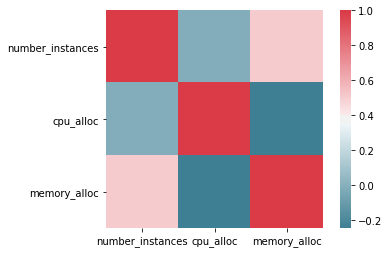

In [60]:
import seaborn as sns
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

# Algorithms Experimentation

## Decision Tree Regressor 

#### 1) Tι συμβαινει αν απλα πεταξω ολες τις γραμμες που εχουν nan values

##### Σε ολα αυτα τα κελια μπορει αντι του Decision Tree Regressor να μπει οποιος αλγοριθμος θελει καποιος να τεσταρει

In [90]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(data_4.drop(columns=['performance', 'served_request','new_performance',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                             ]),
                                                    data_4['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))


0.8068892757435918
375.9697624061207
19.389939721570066


In [43]:
data_4.shape, df_imp.shape

((19839, 10), (19925, 10))

#### 2) Έχοντας κάνει missing values imputation με mean η median

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(df_imp.drop(columns=['performance', 'served_request','new_performance',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                                                                  ]),
                                                    df_imp['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))

0.8031357498039511
375.966141374176
19.38984634735861


#### 3) Έχοντας κάνει missing values imputation με mean η median και μετα normalization

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_imp_norm.drop(columns=['performance', 'served_request',
                                                                              'new_performance',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                                                                  ]),
                                                    df_imp_norm['performance'],random_state=0)
regressor = RandomForestRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))

0.8031405785791005
0.19334145176167072
0.43970609702580965


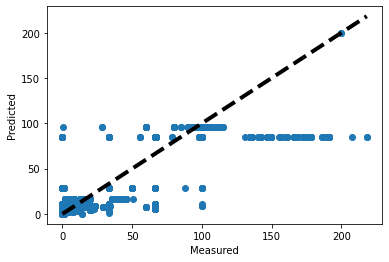

In [91]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

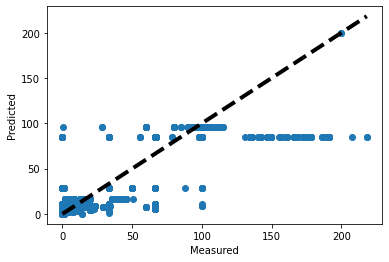

In [92]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(regressor, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Hyperparameter Tuning

In [93]:
from  sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),scoring=scoring,
              param_grid={'min_samples_split': range(2, 10), 
                          'criterion' :('mse', 'friedman_mse', 'mae'),
                         'max_depth':range(1,5)},
               cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

0.8062562009644425

### Regressor, AdaboostRegressor

In [95]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

cross_val_score(regr_1, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))

cross_val_score(regr_2, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))



0.8031405785791005
0.19334145176167072
0.8031405785791005
0.19334145176167072


# Use a stacking regressor. I have chosen 3 different algorithms but it can be any algorithm (that it can be used for regression). Unfortunatelly this technique does not improve the results. 

In [96]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

"""lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))

gradient_pipeline = make_pipeline(
    processor_nlin,
    HistGradientBoostingRegressor(random_state=0))"""

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', LassoCV()),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

stacking_regressor.fit(X_train, y_train)
cross_val_score(stacking_regressor, X_train, y_train, cv=10)
pred = stacking_regressor.predict(X_test)
print(r2_score(y_test, pred))

0.8031176424791533


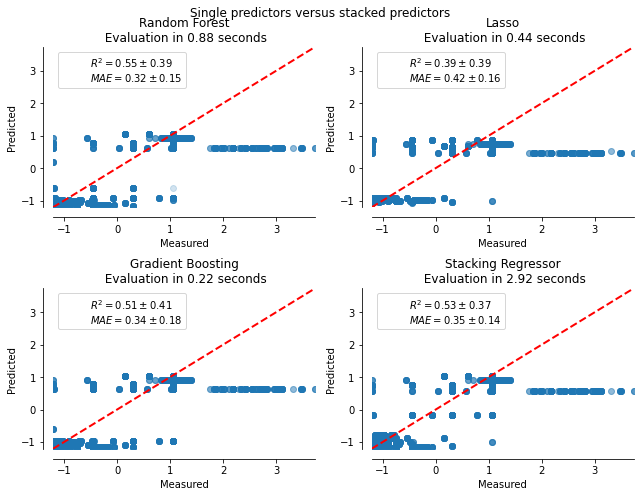

In [98]:
X = df_imp_norm.drop(columns=['performance','new_performance', 'served_request','request_rate', 'response_time', 'memory' , 'cpu_usage'])
y = df_imp_norm['performance']
            
            
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Gradient Boosting Regressor 

In [100]:
## Gradient Boosting Regressor (Metrics as covariates and try to predict performance)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
regr = GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(df_imp_norm.drop(columns=['new_performance','performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage']),
                                                    df_imp_norm['performance'],random_state=0)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(r2_score(y_test, pred))
mse = mean_squared_error(y_test, regr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

0.8030241900747064
The mean squared error (MSE) on test set: 0.1935
